# Lab 07: Credit Card Fraud Detection

---
author: Jakub Szumny
date: October 25, 2024
embed-resources: true
---

## Introduction

Billions of credit card transactions are processed every single day, meaning bank must verify that each one of these transactions is genuine, because credit fraud happens constantly. As a data scientist working for a banking institution, I am tasked with creating an automated fraud detector. The model I am making should take credit card transaction data instantly and determine whether or not the transaction is fraudulent or genuine. I am hoping to find a model that balances false positives and false negatives well, to minimize incorrect predictions. I will be using a classification model for this issue which I am trying to solve.

## Methods

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

### Data

In [2]:
# load data
fraud = pd.read_parquet("https://cs307.org/lab-07/data/fraud.parquet")
fraud_train, fraud_test = train_test_split(
    fraud,
    test_size=0.20,
    random_state=42,
    stratify=fraud["Fraud"],
)

fraud_train

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,Amount,Fraud
57638,-0.514509,0.899378,1.627215,-0.142250,0.005250,-0.235422,0.482540,0.247403,-0.562327,-0.166813,...,-0.143290,-0.390205,0.030719,0.184779,-0.348711,0.073253,0.273217,0.107938,3.59,0
27686,-0.813568,-0.373893,1.152977,-0.449774,-3.868866,2.780636,3.654192,-0.672442,0.753230,-0.662803,...,-0.376783,-0.004239,0.074801,0.124238,-0.448493,0.861423,-0.093639,-0.711632,798.01,0
13321,-2.443142,3.258831,-0.791511,0.223548,0.007932,-1.263044,1.220214,-0.418068,1.860453,4.184883,...,-0.348587,0.531679,0.058990,0.371638,-0.207398,-0.505837,0.524542,-0.343895,1.79,0
28308,-0.397300,0.922104,1.224699,-0.334974,0.322603,-0.117372,0.534683,0.175550,-0.486404,-0.120147,...,-0.239303,-0.695001,-0.128231,-0.536463,-0.138971,0.107526,0.255644,0.100814,2.69,0
54252,1.994046,-0.367813,-0.462867,0.338661,-0.485326,-0.241576,-0.590987,0.089319,1.413224,-0.149292,...,-0.196388,-0.484457,0.421867,0.601393,-0.448014,-0.646256,0.027632,-0.027244,4.49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49499,-0.033583,-0.487672,1.435406,-2.759369,-1.785638,0.402364,-2.306038,-2.287179,0.129717,-1.036412,...,-1.286823,0.824100,0.018890,0.000018,0.301618,0.081215,0.163422,0.252456,10.00,0
29250,-0.731245,1.151677,0.912393,-0.653540,0.700577,-0.461372,1.093273,-0.126254,-0.339171,-0.467356,...,-0.368185,-0.991854,-0.376461,-0.661608,0.554237,0.450650,0.076395,0.096252,6.99,0
31586,2.135923,-0.714182,-1.842502,-0.587267,0.090754,-0.465733,-0.024834,-0.328747,-0.659832,0.853241,...,-0.537267,-1.081138,0.196589,0.087797,-0.111583,0.479888,-0.082523,-0.053305,64.90,0
14898,-0.335632,0.939736,-2.961515,-1.224739,4.446891,2.352092,0.789725,0.609460,-0.746845,-1.580751,...,-0.002116,0.009686,-0.428325,0.536043,0.278736,0.680976,-0.069295,0.051891,0.76,0


The data is from a dataset which contains information on previous credit card transactions, including whether or not they were fraudulent. The data originally is from Kaggle, and it is highly unbalanced as the fraudulent transactions only make up for .172% of all the transactions. The data was also modified which removed the time variable, reduced the number of samples, withheld some data which I will use for the production data, renamed the target variable to Fraud, and renamed the PCA transformed variables.

The dataset includes:

## Response

- **Fraud** `[int64]`:  
  Status of the transaction. 
  - `1` indicates a fraudulent transaction.
  - `0` indicates a genuine (non-fraudulent) transaction.

## Features

- **Amount** `[float64]`:  
  Amount (in dollars) of the transaction.

- **PC01 - PC28** `[float64]`:  
  The 28 principal components that encode information such as location and type of purchase while preserving customer privacy.


In [3]:
# summary statistics
print("Num of Samples: ", len(fraud_train))
print("Num of Features: ", fraud_train.shape[1] - 1)

Num of Samples:  54276
Num of Features:  29


In [4]:
prop = fraud_train.groupby("Fraud").size()
print("Counts:", prop)
print("Proportions:", (prop/prop.sum()))

Counts: Fraud
0    53961
1      315
dtype: int64
Proportions: Fraud
0    0.994196
1    0.005804
dtype: float64


In [6]:
print("Fraud (None):")
print("Mean:", fraud_train["Amount"].mean())
print("STD:", fraud_train["Amount"].std())
print("Median:", np.median(fraud_train["Amount"]))
print("Maximum:", np.max(fraud_train["Amount"]))
print("")
print("Fraud (0):")
print("Mean:", fraud_train[fraud_train["Fraud"] == 0]["Amount"].mean())
print("STD:", fraud_train[fraud_train["Fraud"] == 0]["Amount"].std())
print("Median:", np.median(fraud_train[fraud_train["Fraud"] == 0]["Amount"]))
print("Maximum:", np.max(fraud_train[fraud_train["Fraud"] == 0]["Amount"]))
print("")
print("Fraud (1):")
print("Mean:", fraud_train[fraud_train["Fraud"] == 1]["Amount"].mean())
print("STD:", fraud_train[fraud_train["Fraud"] == 1]["Amount"].std())
print("Median:", np.median(fraud_train[fraud_train["Fraud"] == 1]["Amount"]))
print("Maximum:", np.max(fraud_train[fraud_train["Fraud"] == 1]["Amount"]))

Fraud (None):
Mean: 88.19790275628269
STD: 241.53561659607715
Median: 21.69
Maximum: 10199.44

Fraud (0):
Mean: 88.06510368599545
STD: 241.45114392494762
Median: 21.8
Maximum: 10199.44

Fraud (1):
Mean: 110.94701587301587
STD: 254.97895988379767
Median: 6.99
Maximum: 2125.87


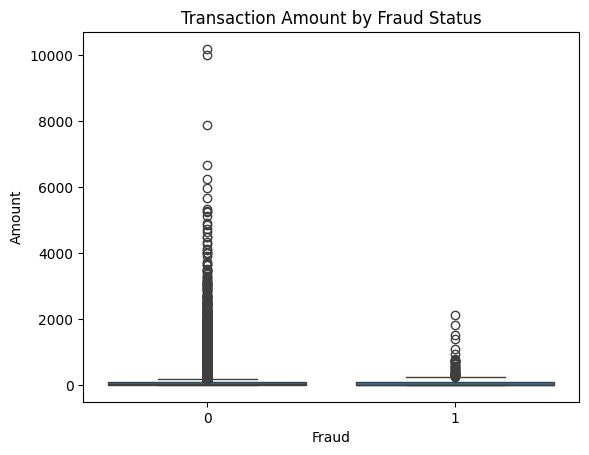

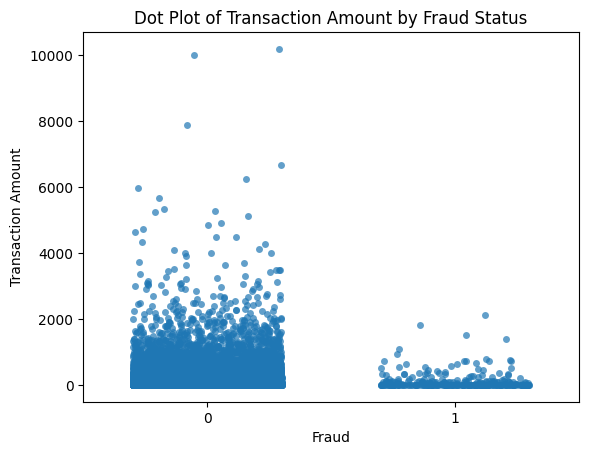

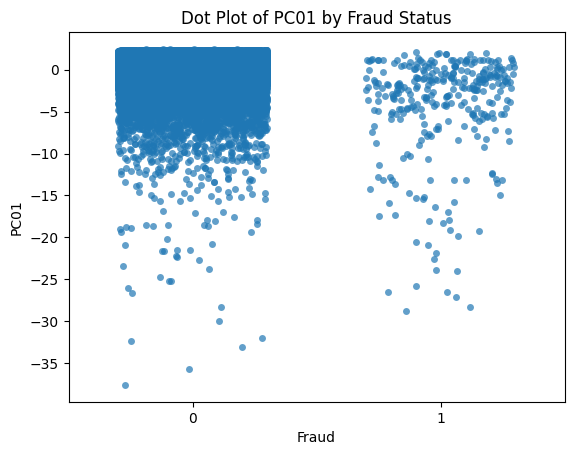

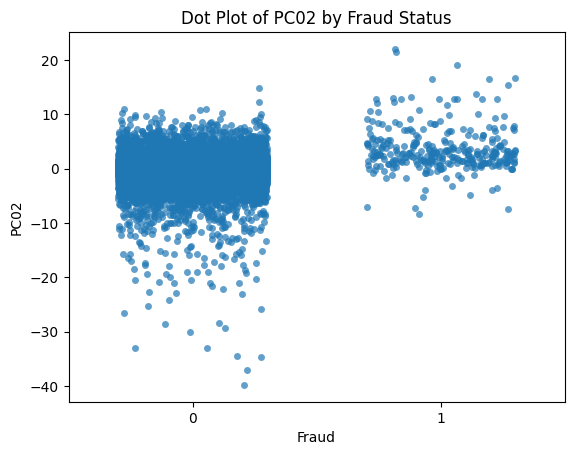

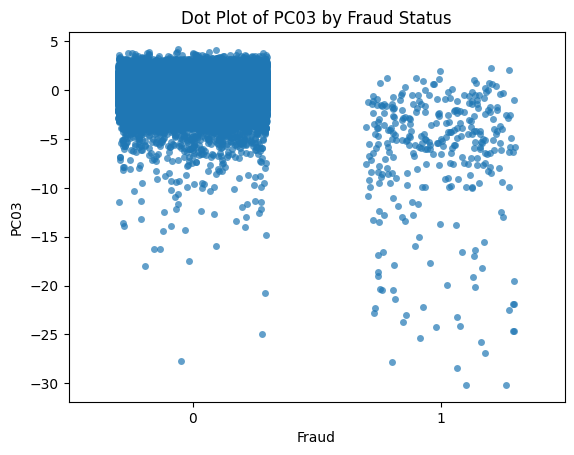

In [19]:
# visualizations
sns.boxplot(x='Fraud', y='Amount', data=fraud_train)
plt.title('Transaction Amount by Fraud Status')
plt.show()

sns.stripplot(x='Fraud', y='Amount', data=fraud_train, jitter=0.3, alpha=0.7)
plt.title('Dot Plot of Transaction Amount by Fraud Status')
plt.xlabel('Fraud')
plt.ylabel('Transaction Amount')
plt.show()

for pc in ['PC01', 'PC02', 'PC03']:
    sns.stripplot(x='Fraud', y=pc, data=fraud_train, jitter=0.3, alpha=0.7)
    plt.title(f'Dot Plot of {pc} by Fraud Status')
    plt.xlabel('Fraud')
    plt.ylabel(pc)
    plt.show()

Based off of the summary statistics and visualizations, that there are some rather big differences between fraudulent data and genuine data. First of course I notice that there is a significantly lower amount of fraudelent data than genuine data, which definitely is not the best sign. Then in the plots we can see that fraudulent transaction seem to be in smaller amounts than genuine transactions, which is a large clue. Then when we look at some of the selected PC features we can see that it does look different, but it seems to follow similar patterns whether it is fraudulent or not, and this is likely because of how little samples we have of fraudulent data, it is really hard to find any great correlations.

### Models

In [20]:
# process data for ML
# create X and y for train
X_train = fraud_train.drop("Fraud", axis=1)
y_train = fraud_train["Fraud"]

# create X and y for test
X_test = fraud_test.drop("Fraud", axis=1)
y_test = fraud_test["Fraud"]

In [25]:
# train models
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()

# define preprocessing for numeric features
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

# define preprocessing for categorical features
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder()),
    ]
)

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# create pipeline, preprocess then classify
pipeline = Pipeline(
    steps=[
        # ("preprocessor", preprocessor),
        # ("classifier", LogisticRegression()),
        ("classifier", RandomForestClassifier())

    ]
)

# define parameter grid
param_grid = {
    "classifier__n_estimators": [50, 100],
    "classifier__max_depth": [3, 5],
    "classifier__class_weight": ["balanced"]
    }

# # setup grid search with cross-validation
scoring = {'precision': 'precision', 'recall': 'recall', 'accuracy': 'accuracy', "f1": 'f1'}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring, refit='precision')

# run grid search with cross-validation
grid_search.fit(X_train, y_train)

# print best parameters found and best (cross-validated) score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation precision: {grid_search.best_score_}")

Best parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Best cross-validation precision: 0.7778198602868095


Here I used a pipeline and a grid search cross validation to find the best parameters for this model, using a Random Forest Classifier. I found that the best class weight was balanced, the best max depth was 5, and the best n estimators was 100. From this I recieved a cross-validation precision of 0.7778, which is a good sign.

## Results

In [26]:
print(f"Best parameters: {grid_search.best_params_}")
print("Recall:", grid_search.cv_results_[f'mean_test_recall'][grid_search.best_index_])
print("Precision:", grid_search.cv_results_[f'mean_test_precision'][grid_search.best_index_])
print("F1 Score:", grid_search.cv_results_[f'mean_test_f1'][grid_search.best_index_])
print("Accuracy:", grid_search.cv_results_[f'mean_test_accuracy'][grid_search.best_index_])

from joblib import dump
dump(grid_search, "credit-fraud.joblib")

Best parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Recall: 0.8539682539682539
Precision: 0.7778198602868095
F1 Score: 0.8112821773299952
Accuracy: 0.9976601001273911


['credit-fraud.joblib']

The model recieved a recall of 0.854, a precision of 0.7778, an F1 Score of .81, and an accuracy of .998. These are really good and show that the model is very accurate.

## Discussion

After recieving all of the model metrics, and seeing that the recall is .854, and precision is .7778 is a great sign. Precision is the proportion of true positives out of all predicted positives, which is very good, and recall is the proportion of true positives out of true positives and false negatives. Both of these are very high, but it shows there was a decent amount of false positives, but a smaller amount of false negatives.

I think that that in this case, recall is more important, as it is the proportion of true positives out of true positives and false negatives. False negatives is bad in this case, because that means that there was fraud that wasn't caught by the model, which is very bad. The higher the recall the less false negatives there are which is important. Precision is still important but it is the proportion of tru positives out of all predicted positives, and a false positive is much better than a false negative, because it can be easily solved with a simple call.

Both of these numbers were rather high, which is a good sign, but they could definitely be refined and made even higher, maybe by using other types of data as factors, or making the model better in some way. Realistically the only thing that needs to be really high is recall, as it shows that there are less false negatives.



### Conclusion

To conclude, given the highly accurate performance of the model, and given the somewhat high recall and precision, I would say this model is off to a good start, but it could definitely be better. Credit fraud is not a good thing, and having too many false negatives get by could really harm people's money, as sometimes even they won't catch it on their statements. I think more work should be put into this before it is used in the real world, but it definitely is a great start, and as long as the recall is increased, that this model could definitely be used in the real world. Detecting fraud is a very difficult task to do, because you never know if it really is the person, or if their credit has been stolen. It is pretty important for the model to have a high recall, but doesn't necessarily need as high of a precision, as false positives can be easily fixed, whereas false negatives are much more difficult to deal with.